randomly choose seed - 56876
845.34678 
845.34678 
845.34678 
-------------------------------------\
temperature is 37.00 degrees celsius
dt is 0.0250 ms
-------------------------------------/
...
------------------------------------------------------------------------------\
NetCon[1276].event()
5951
NetCon[1276].event()
-----------------------------------------------------------
finished simulation 1: num output spikes = 0
------------------------------------------------------------------------------/
...
------------------------------------------------------------------------------\
NetCon[2554].event()
5945
NetCon[2554].event()
-----------------------------------------------------------
finished simulation 2: num output spikes = 0
------------------------------------------------------------------------------/
...
------------------------------------------------------------------------------\
NetCon[3832].event()
5897
NetCon[3832].event()
--------------------------------------------

/Users/gili/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gili/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/gili/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gili/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gili/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-----------------------------------------------
total number of collected spikes is 0
average output frequency is 0.00 [Hz]
ISI-CV is nan
-------------------------------------------------/


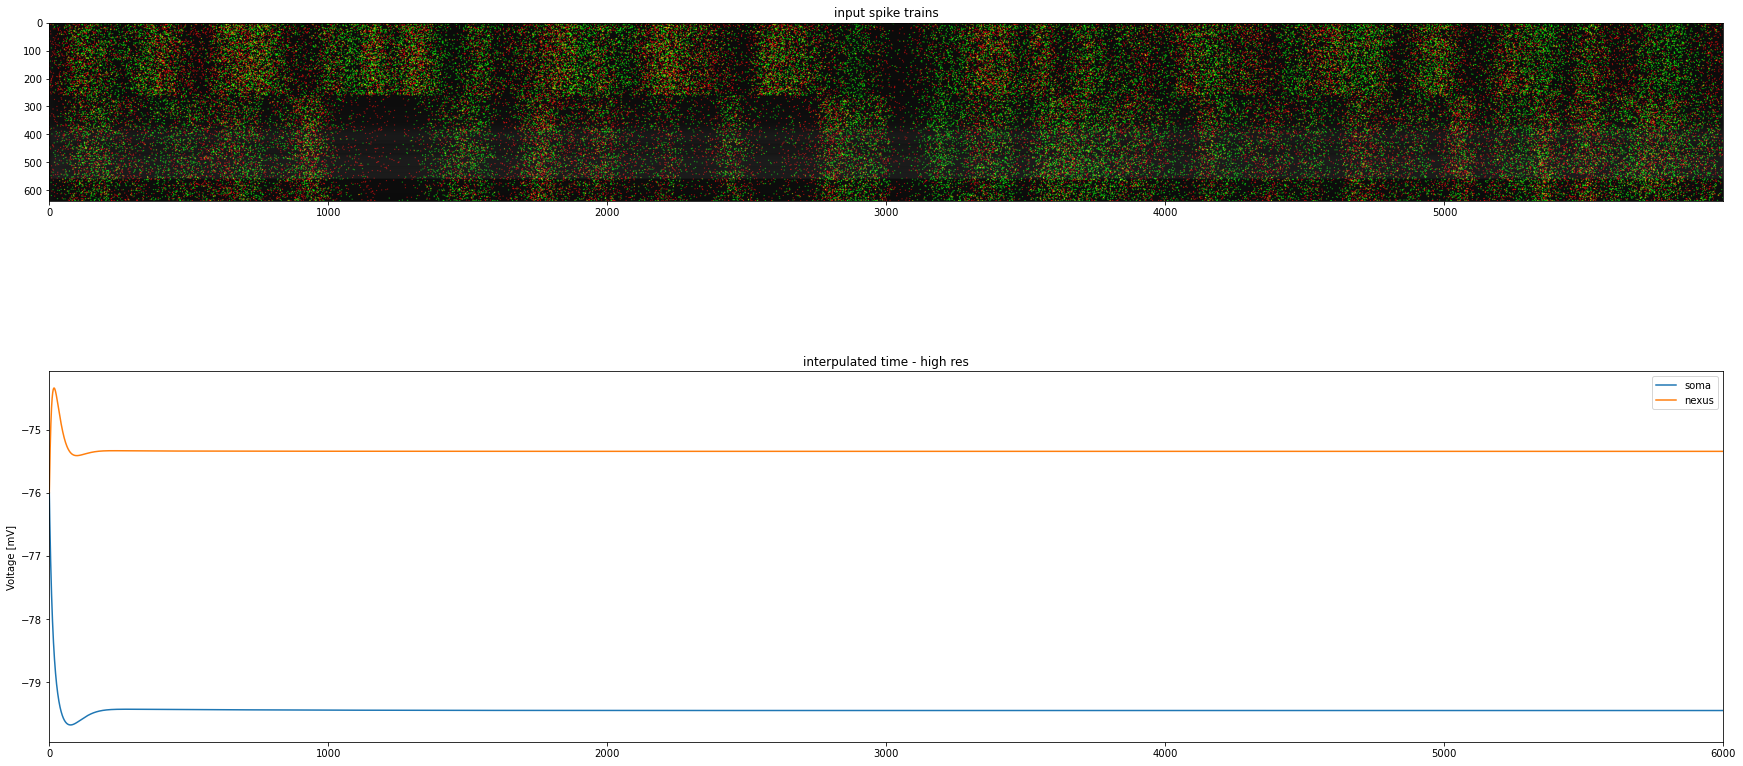

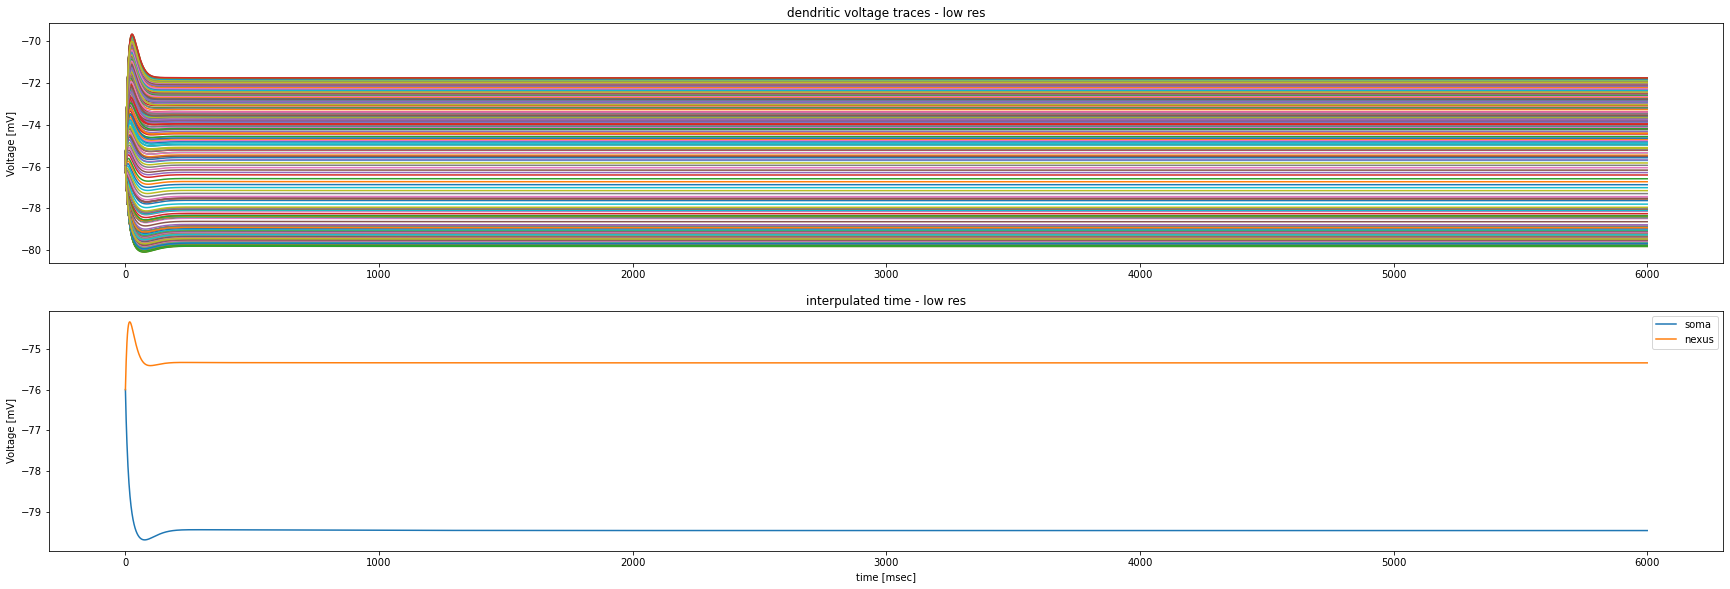

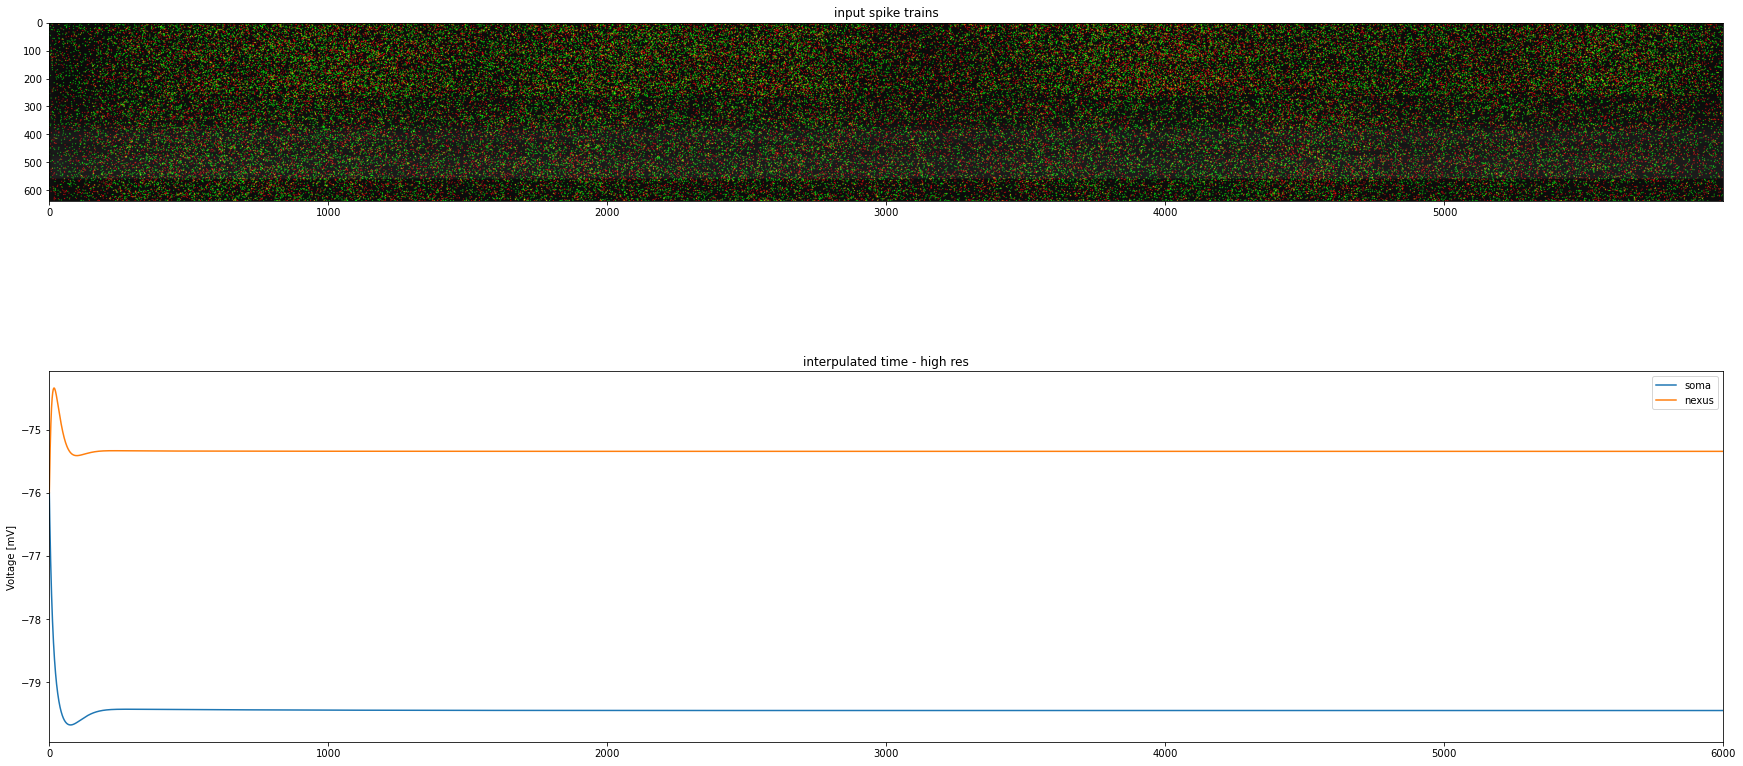

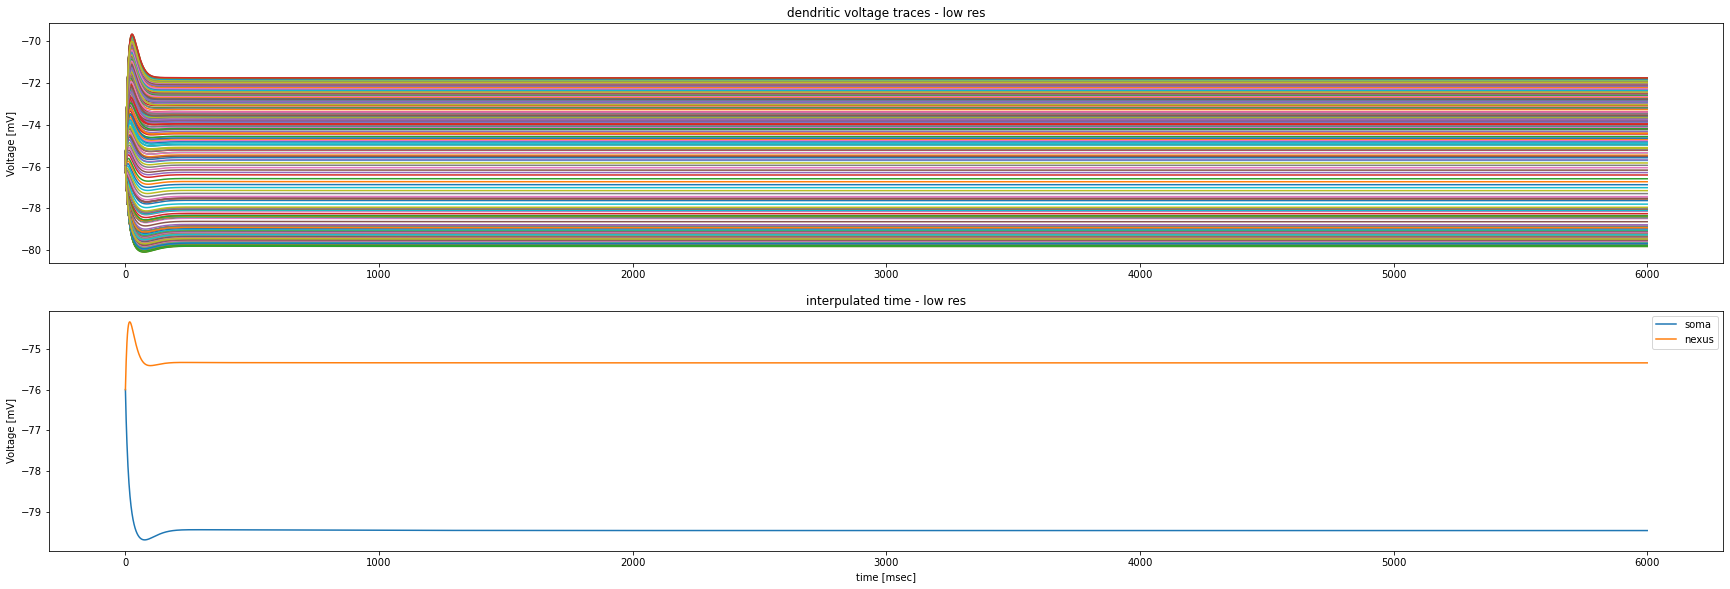

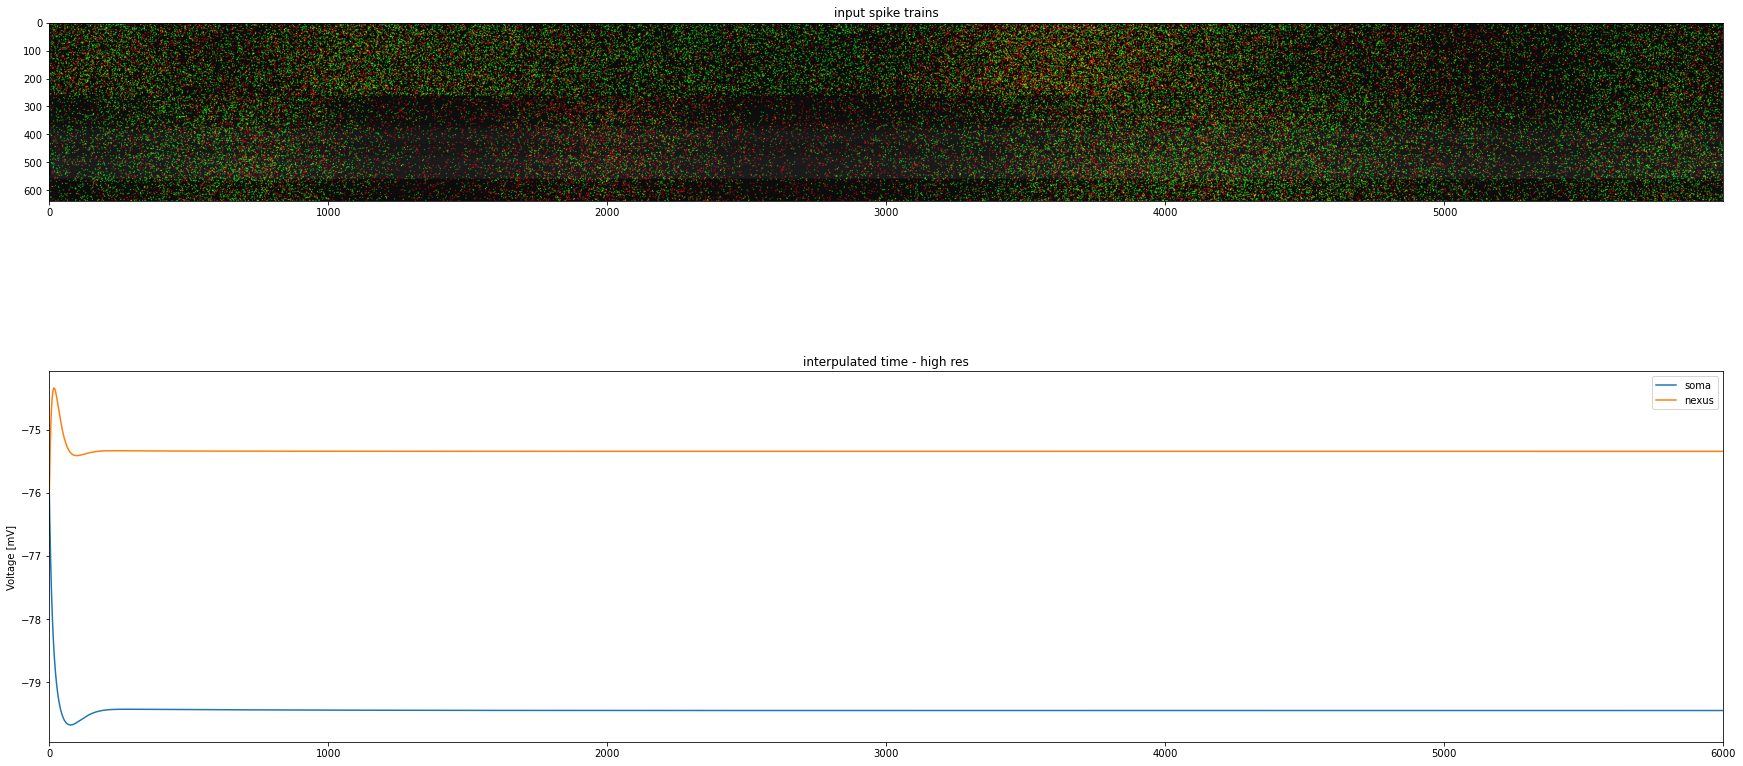

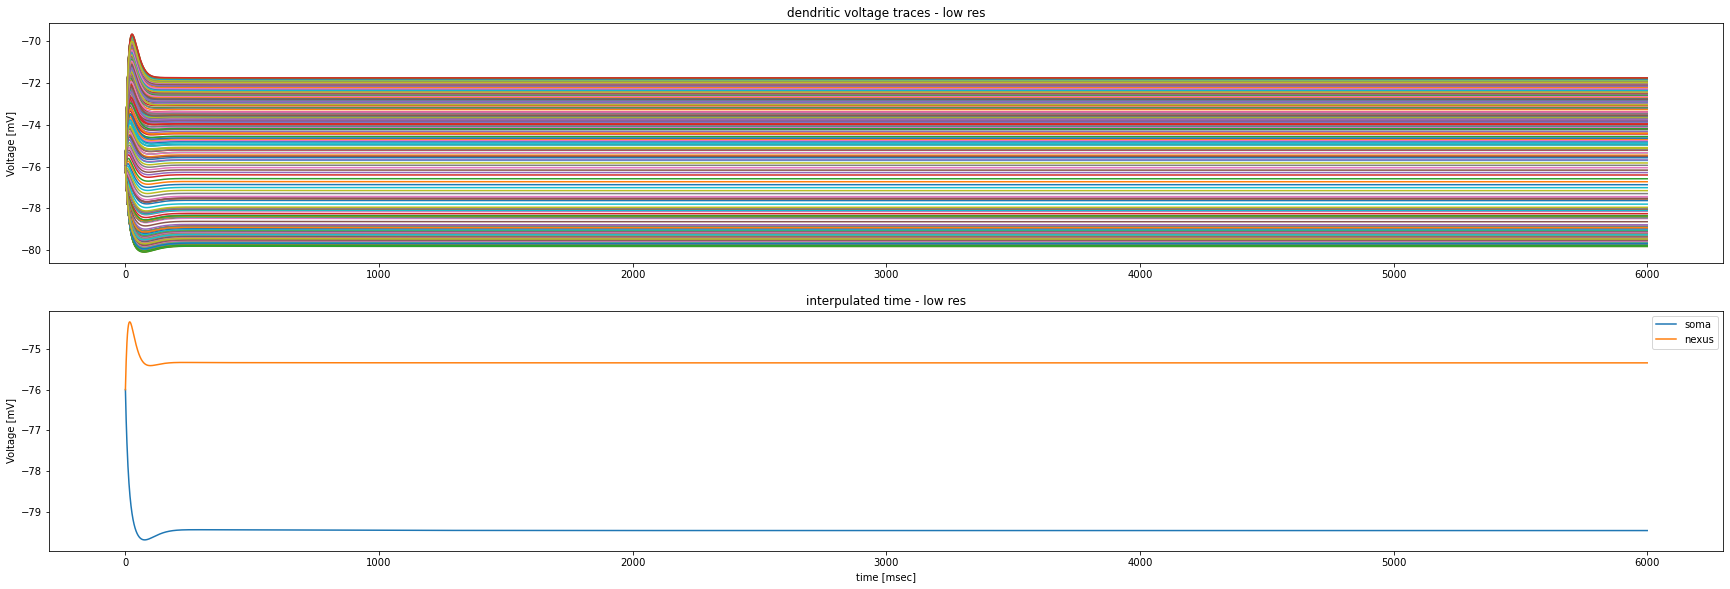

In [1]:
import os
import sys
import numpy as np
from scipy import signal
# import time
import neuron
from neuron import h
from neuron import gui
from neuron.units import ms, mV

# get or randomly generate random seed
try:
    randomSeed = int(sys.argv[1])
    print('random seed selected by user - %d' %(randomSeed))
except:
    randomSeed = np.random.randint(100000)
    print('randomly choose seed - %d' %(randomSeed))

np.random.seed(randomSeed)


#%% define simulation params

# general simulation parameters
numSimulations = 3
totalSimDurationInSec = 6

# switch whether to store dendritic voltage traces (DVTs), which take up a lot of storage
collectAndSaveDVTs = True

# high res sampling of the voltage and nexus voltages
numSamplesPerMS_HighRes = 8

# synapse type
excitatorySynapseType = 'NMDA'    # supported options: {'AMPA','NMDA'}
# excitatorySynapseType = 'AMPA'    # supported options: {'AMPA','NMDA'}
inhibitorySynapseType = 'GABA_A'

# use active dendritic conductances switch
useActiveDendrites = True

# attenuation factor for the conductance of the SK channel
SKE2_mult_factor = 1.0
# SKE2_mult_factor = 0.1

# determine the voltage activation curve of the Ih current (HCN channel)
Ih_vshift = 0

# simulation duration
sim_duration_sec = totalSimDurationInSec
sim_duration_ms  = 1000 * sim_duration_sec

# define inst rate between change interval and smoothing sigma options
inst_rate_sampling_time_interval_options_ms   = [25,30,35,40,45,55,60,65,70,75,80,85,90,100,150,200,300,450]
temporal_inst_rate_smoothing_sigma_options_ms = [25,30,35,40,50,60,80,100,150,200,300,400,500,600]

inst_rate_sampling_time_interval_jitter_range   = 20
temporal_inst_rate_smoothing_sigma_jitter_range = 20

# number of spike ranges for the simulation

# AMPA with attenuated SK_E2 conductance
#num_bas_ex_spikes_per_100ms_range = [0,1900]
#num_bas_ex_inh_spike_diff_per_100ms_range = [-1500,300]
#num_apic_ex_spikes_per_100ms_range = [0,2000]
#num_apic_ex_inh_spike_diff_per_100ms_range = [-1500,300]

# AMPA
#num_bas_ex_spikes_per_100ms_range = [0,1900]
#num_bas_ex_inh_spike_diff_per_100ms_range = [-1650,150]
#num_apic_ex_spikes_per_100ms_range = [0,2000]
#num_apic_ex_inh_spike_diff_per_100ms_range = [-1650,150]

# NMDA
num_bas_ex_spikes_per_100ms_range = [0,800]
num_bas_ex_inh_spike_diff_per_100ms_range = [-600,200]
num_apic_ex_spikes_per_100ms_range = [0,800]
num_apic_ex_inh_spike_diff_per_100ms_range = [-600,200]

# "regularization" param for the segment lengths (mainly used to not divide by very small numbers)
min_seg_length_um = 10.0

# beaurrocracy
showPlots = True
resultsSavedIn_rootFolder = '/Users/gili/neuronout/'

useCvode = True
totalSimDurationInMS = 1000 * totalSimDurationInSec

#%% define some helper functions


def generate_input_spike_trains_for_simulation(sim_duration_ms, basal_seg_length_um, apical_seg_length_um, min_seg_length_um,
                                               num_bas_ex_spikes_per_100ms_range, num_apic_ex_spikes_per_100ms_range,
                                               num_bas_ex_inh_spike_diff_per_100ms_range, num_apic_ex_inh_spike_diff_per_100ms_range,
                                               inst_rate_sampling_time_interval_options_ms, temporal_inst_rate_smoothing_sigma_options_ms):
    
    # extract the number of basal and apical segments
    num_basal_segments  = len(basal_seg_length_um)
    num_apical_segments = len(apical_seg_length_um)
        
    # adjust segment lengths (with "min_seg_length_um")
    adjusted_basal_length_um  = min_seg_length_um + basal_seg_length_um
    adjusted_apical_length_um = min_seg_length_um + apical_seg_length_um
    
    # calc sum of seg length (to be used for normalization later on)
    total_adjusted_basal_tree_length_um  = adjusted_basal_length_um.sum()
    total_adjusted_apical_tree_length_um = adjusted_apical_length_um.sum()
    
    # randomly sample inst rate (with some uniform noise) smoothing sigma
    keep_inst_rate_const_for_ms = inst_rate_sampling_time_interval_options_ms[np.random.randint(len(inst_rate_sampling_time_interval_options_ms))]
    keep_inst_rate_const_for_ms += int(2 * inst_rate_sampling_time_interval_jitter_range * np.random.rand() - inst_rate_sampling_time_interval_jitter_range)
    
    # randomly sample smoothing sigma (with some uniform noise)
    temporal_inst_rate_smoothing_sigma = temporal_inst_rate_smoothing_sigma_options_ms[np.random.randint(len(temporal_inst_rate_smoothing_sigma_options_ms))]
    temporal_inst_rate_smoothing_sigma += int(2 * temporal_inst_rate_smoothing_sigma_jitter_range * np.random.rand() - temporal_inst_rate_smoothing_sigma_jitter_range)
    
    num_inst_rate_samples = int(np.ceil(float(sim_duration_ms) / keep_inst_rate_const_for_ms))
    
    # create the coarse inst rates with units of "total spikes per tree per 100 ms"
    num_bas_ex_spikes_per_100ms   = np.random.uniform(low=num_bas_ex_spikes_per_100ms_range[0], high=num_bas_ex_spikes_per_100ms_range[1], size=(1,num_inst_rate_samples))
    num_bas_inh_spikes_low_range  = np.maximum(0, num_bas_ex_spikes_per_100ms + num_bas_ex_inh_spike_diff_per_100ms_range[0])
    num_bas_inh_spikes_high_range = num_bas_ex_spikes_per_100ms + num_bas_ex_inh_spike_diff_per_100ms_range[1]
    num_bas_inh_spikes_per_100ms  = np.random.uniform(low=num_bas_inh_spikes_low_range, high=num_bas_inh_spikes_high_range, size=(1,num_inst_rate_samples))
    
    num_apic_ex_spikes_per_100ms   = np.random.uniform(low=num_apic_ex_spikes_per_100ms_range[0], high=num_apic_ex_spikes_per_100ms_range[1],size=(1,num_inst_rate_samples))
    num_apic_inh_spikes_low_range  = np.maximum(0, num_apic_ex_spikes_per_100ms + num_apic_ex_inh_spike_diff_per_100ms_range[0])
    num_apic_inh_spikes_high_range = num_apic_ex_spikes_per_100ms + num_apic_ex_inh_spike_diff_per_100ms_range[1]
    num_apic_inh_spikes_per_100ms  = np.random.uniform(low=num_apic_inh_spikes_low_range, high=num_apic_inh_spikes_high_range, size=(1,num_inst_rate_samples))
    
    # convert to units of "per_1um_per_1ms"
    ex_bas_spike_rate_per_1um_per_1ms   = num_bas_ex_spikes_per_100ms   / (total_adjusted_basal_tree_length_um  * 100.0)
    inh_bas_spike_rate_per_1um_per_1ms  = num_bas_inh_spikes_per_100ms  / (total_adjusted_basal_tree_length_um  * 100.0)
    ex_apic_spike_rate_per_1um_per_1ms  = num_apic_ex_spikes_per_100ms  / (total_adjusted_apical_tree_length_um * 100.0)
    inh_apic_spike_rate_per_1um_per_1ms = num_apic_inh_spikes_per_100ms / (total_adjusted_apical_tree_length_um * 100.0)
            
    # kron by space (uniform distribution across branches per tree)
    ex_bas_spike_rate_per_seg_per_1ms   = np.kron(ex_bas_spike_rate_per_1um_per_1ms  , np.ones((num_basal_segments,1)))
    inh_bas_spike_rate_per_seg_per_1ms  = np.kron(inh_bas_spike_rate_per_1um_per_1ms , np.ones((num_basal_segments,1)))
    ex_apic_spike_rate_per_seg_per_1ms  = np.kron(ex_apic_spike_rate_per_1um_per_1ms , np.ones((num_apical_segments,1)))
    inh_apic_spike_rate_per_seg_per_1ms = np.kron(inh_apic_spike_rate_per_1um_per_1ms, np.ones((num_apical_segments,1)))
        
    # vstack basal and apical
    ex_spike_rate_per_seg_per_1ms  = np.vstack((ex_bas_spike_rate_per_seg_per_1ms , ex_apic_spike_rate_per_seg_per_1ms))
    inh_spike_rate_per_seg_per_1ms = np.vstack((inh_bas_spike_rate_per_seg_per_1ms, inh_apic_spike_rate_per_seg_per_1ms))
    
    # add some spatial multiplicative randomness (that will be added to the sampling noise)
    ex_spike_rate_per_seg_per_1ms  = np.random.uniform(low=0.5, high=1.5, size=ex_spike_rate_per_seg_per_1ms.shape ) * ex_spike_rate_per_seg_per_1ms
    inh_spike_rate_per_seg_per_1ms = np.random.uniform(low=0.5, high=1.5, size=inh_spike_rate_per_seg_per_1ms.shape) * inh_spike_rate_per_seg_per_1ms
    
    # concatenate the adjusted length
    adjusted_length_um = np.hstack((adjusted_basal_length_um, adjusted_apical_length_um))
    
    # multiply each segment by it's length (now every segment will have firing rate proportional to it's length)
    ex_spike_rate_per_seg_per_1ms  = ex_spike_rate_per_seg_per_1ms  * np.tile(adjusted_length_um[:,np.newaxis], [1, ex_spike_rate_per_seg_per_1ms.shape[1]])
    inh_spike_rate_per_seg_per_1ms = inh_spike_rate_per_seg_per_1ms * np.tile(adjusted_length_um[:,np.newaxis], [1, inh_spike_rate_per_seg_per_1ms.shape[1]])
        
    # kron by time (crop if there are leftovers in the end) to fill up the time to 1ms time bins
    ex_spike_rate_per_seg_per_1ms  = np.kron(ex_spike_rate_per_seg_per_1ms , np.ones((1,keep_inst_rate_const_for_ms)))[:,:sim_duration_ms]
    inh_spike_rate_per_seg_per_1ms = np.kron(inh_spike_rate_per_seg_per_1ms, np.ones((1,keep_inst_rate_const_for_ms)))[:,:sim_duration_ms]
    
    # filter the inst rates according to smoothing sigma
    smoothing_window = signal.gaussian(1.0 + 7 * temporal_inst_rate_smoothing_sigma, std=temporal_inst_rate_smoothing_sigma)[np.newaxis,:]
    smoothing_window /= smoothing_window.sum()
    seg_inst_rate_ex_smoothed  = signal.convolve(ex_spike_rate_per_seg_per_1ms,  smoothing_window, mode='same')
    seg_inst_rate_inh_smoothed = signal.convolve(inh_spike_rate_per_seg_per_1ms, smoothing_window, mode='same')
    
    # sample the instantanous spike prob and then sample the actual spikes
    ex_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_ex_smoothed)
    ex_spikes_bin      = np.random.rand(ex_inst_spike_prob.shape[0], ex_inst_spike_prob.shape[1]) < ex_inst_spike_prob
    
    inh_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_inh_smoothed)
    inh_spikes_bin      = np.random.rand(inh_inst_spike_prob.shape[0], inh_inst_spike_prob.shape[1]) < inh_inst_spike_prob
    
    return ex_spikes_bin, inh_spikes_bin


def GetDirNameAndFileName(numOutputSpikes, randomSeed):
    # string to describe model name based on params

    cellType = 'L5PC'
    synapseTypes    = excitatorySynapseType + '_' + inhibitorySynapseType
    dendritesKind = 'activeDendrites'
    if not useActiveDendrites:
        dendritesKind = 'passiveDendrites'
    else:
        dendritesKind += '_Ih_vshift_%d_SKE2_mult_%d' %(Ih_vshift, 100 * SKE2_mult_factor)
        
    modelString = cellType + '__' + dendritesKind + '__' + synapseTypes
    dirToSaveIn = resultsSavedIn_rootFolder + modelString + '//'
    
    # string to describe input
    string1 = 'exBas_%d_%d_inhBasDiff_%d_%d' %(num_bas_ex_spikes_per_100ms_range[0],num_bas_ex_spikes_per_100ms_range[1],
                                               num_bas_ex_inh_spike_diff_per_100ms_range[0],num_bas_ex_inh_spike_diff_per_100ms_range[1])
    string2 = 'exApic_%d_%d_inhApicDiff_%d_%d' %(num_apic_ex_spikes_per_100ms_range[0],num_apic_ex_spikes_per_100ms_range[1],
                                                 num_apic_ex_inh_spike_diff_per_100ms_range[0],num_apic_ex_inh_spike_diff_per_100ms_range[1])
    inputString = string1 + '__' + string2
    
    # string to describe simulation
    savedDVTs = ''
    if collectAndSaveDVTs:
        savedDVTs = 'DVTs'
    
    string3 = 'saved_InputSpikes_%s__%d_outSpikes__%d_simulationRuns__%d_secDuration__randomSeed_%d'
    simulationString = string3 %(savedDVTs, numOutputSpikes, numSimulations,totalSimDurationInSec, randomSeed)
                  
    filenameToSave = inputString + '__' + simulationString + '.p'
                 
    return dirToSaveIn, filenameToSave


def GetDistanceBetweenSections(sourceSection, destSection):
    h.distance(sec=sourceSection)
    return h.distance(0, sec=destSection)


# AMPA synapse
def DefineSynapse_AMPA(segment, gMax=0.0004):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 0.3
    synapse.tau_d = 3.0
    synapse.gmax = gMax
    synapse.e = 0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# NMDA synapse
def DefineSynapse_NMDA(segment, gMax=0.0004):
    synapse = h.ProbAMPANMDA2(segment)

    synapse.tau_r_AMPA = 0.3
    synapse.tau_d_AMPA = 3.0
    synapse.tau_r_NMDA = 2.0
    synapse.tau_d_NMDA = 70.0
    synapse.gmax = gMax
    synapse.e = 0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA A synapse
def DefineSynapse_GABA_A(segment, gMax=0.001):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 0.2
    synapse.tau_d = 8
    synapse.gmax = gMax
    synapse.e = -80
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA B synapse
def DefineSynapse_GABA_B(segment, gMax=0.001):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 3.5
    synapse.tau_d = 260.9
    synapse.gmax = gMax
    synapse.e = -97
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA A+B synapse
def DefineSynapse_GABA_AB(segment, gMax=0.001):
    synapse = h.ProbGABAAB_EMS(segment)

    synapse.tau_r_GABAA = 0.2
    synapse.tau_d_GABAA = 8
    synapse.tau_r_GABAB = 3.5
    synapse.tau_d_GABAB = 260.9
    synapse.gmax = gMax
    synapse.e_GABAA = -80
    synapse.e_GABAB = -97
    synapse.GABAB_ratio = 0.0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


def ConnectEmptyEventGenerator(synapse):

    netConnection = h.NetCon(None,synapse)
    netConnection.delay = 0
    netConnection.weight[0] = 1

    return netConnection


# create a single image of both excitatory and inhibitory spikes and the dendritic voltage traces
def CreateCombinedColorImage(dendriticVoltageTraces, excitatoryInputSpikes, inhibitoryInputSpikes):
    minV = -85
    maxV = 35
    
    excitatoryInputSpikes = signal.fftconvolve(excitatoryInputSpikes, np.ones((3,3)), mode='same')
    inhibitoryInputSpikes = signal.fftconvolve(inhibitoryInputSpikes, np.ones((3,3)), mode='same')
    
    stimulationImage = np.zeros((np.shape(excitatoryInputSpikes)[0],np.shape(excitatoryInputSpikes)[1],3))
    stimulationImage[:,:,0] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV) + inhibitoryInputSpikes
    stimulationImage[:,:,1] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV) + excitatoryInputSpikes
    stimulationImage[:,:,2] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV)
    stimulationImage[stimulationImage > 1] = 1

    return stimulationImage


#%% define NEURON model

h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "morphologies/cell1.asc"
biophysicalModelFilename = "L5PCbiophysWhat.hoc"
biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"
h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
L5PC = h.L5PCtemplate(morphologyFilename)
h.celsius = 37

cvode = h.CVode()
if useCvode:
    cvode.active(1)

#%% collect everything we need about the model

# Get a list of all sections
listOfBasalSections  = [L5PC.dend[x] for x in range(len(L5PC.dend))]
listOfApicalSections = [L5PC.apic[x] for x in range(len(L5PC.apic))]
allSections = listOfBasalSections + listOfApicalSections
allSectionsType = ['basal' for x in listOfBasalSections] + ['apical' for x in listOfApicalSections]
allSectionsLength = []
allSections_DistFromSoma = []

allSegments = []
allSegmentsLength = []
allSegmentsType = []
allSegments_DistFromSoma = []
allSegments_SectionDistFromSoma = []
allSegments_SectionInd = []
# get a list of all segments
for k, section in enumerate(allSections):
    allSectionsLength.append(section.L)
    allSections_DistFromSoma.append(GetDistanceBetweenSections(L5PC.soma[0], section))
    for currSegment in section:
        allSegments.append(currSegment)
        allSegmentsLength.append(float(section.L) / section.nseg)
        allSegmentsType.append(allSectionsType[k])
        allSegments_DistFromSoma.append(GetDistanceBetweenSections(L5PC.soma[0], section) + float(section.L) * currSegment.x)
        allSegments_SectionDistFromSoma.append(GetDistanceBetweenSections(L5PC.soma[0], section))
        allSegments_SectionInd.append(k)


# set Ih vshift value and SK multiplicative factor
for section in allSections:
    section.vshift_Ih = Ih_vshift
L5PC.soma[0].vshift_Ih = Ih_vshift

list_of_axonal_sections = [L5PC.axon[x] for x in range(len(L5PC.axon))]
list_of_somatic_sections = [L5PC.soma[x] for x in range(len(L5PC.soma))]
all_sections_with_SKE2 = list_of_somatic_sections + listOfApicalSections

for section in all_sections_with_SKE2:
    orig_SKE2_g = section.gSK_E2bar_SK_E2
    new_SKE2_g = orig_SKE2_g * SKE2_mult_factor
    section.gSK_E2bar_SK_E2 = new_SKE2_g
    #print('SKE2 conductance before update = %.10f' %(orig_SKE2_g))
    #print('SKE2 conductance after  update = %.10f (actual)' %(section.gSK_E2bar_SK_E2))

# Calculate total dendritic length
numBasalSegments = 0
numApicalSegments = 0
totalBasalDendriticLength = 0
totalApicalDendriticLength = 0

basal_seg_length_um = []
apical_seg_length_um = []
for k, segmentLength in enumerate(allSegmentsLength):
    if allSegmentsType[k] == 'basal':
        basal_seg_length_um.append(segmentLength)
        totalBasalDendriticLength += segmentLength
        numBasalSegments += 1
    if allSegmentsType[k] == 'apical':
        apical_seg_length_um.append(segmentLength)
        totalApicalDendriticLength += segmentLength
        numApicalSegments += 1

totalDendriticLength = sum(allSectionsLength)
totalNumSegments = len(allSegments)

# extract basal and apical segment lengths
num_basal_segments  = len(basal_seg_length_um)
num_apical_segments = len(apical_seg_length_um)

basal_seg_length_um = np.array(basal_seg_length_um)
apical_seg_length_um = np.array(apical_seg_length_um)

assert(totalNumSegments == (numBasalSegments + numApicalSegments))
assert(abs(totalDendriticLength - (totalBasalDendriticLength + totalApicalDendriticLength)) < 0.00001)

totalNumOutputSpikes = 0
numOutputSpikesPerSim = []
listOfISIs = []
listOfSingleSimulationDicts = []

## run all simulations
experimentStartTime = 0
print('-------------------------------------\\')
print('temperature is %.2f degrees celsius' %(h.celsius))
print('dt is %.4f ms' %(h.dt))
print('-------------------------------------/')
for simInd in range(numSimulations):
    currSimulationResultsDict = {}
    print('...')
    print('------------------------------------------------------------------------------\\')


    ex_spikes_bin, inh_spikes_bin = generate_input_spike_trains_for_simulation(sim_duration_ms,
                                                                               basal_seg_length_um,
                                                                               apical_seg_length_um,
                                                                               min_seg_length_um,
                                                                               num_bas_ex_spikes_per_100ms_range,
                                                                               num_apic_ex_spikes_per_100ms_range,
                                                                               num_bas_ex_inh_spike_diff_per_100ms_range,
                                                                               num_apic_ex_inh_spike_diff_per_100ms_range,
                                                                               inst_rate_sampling_time_interval_options_ms,
                                                                               temporal_inst_rate_smoothing_sigma_options_ms)

    inputSpikeTrains_ex  = ex_spikes_bin
    inputSpikeTrains_inh = inh_spikes_bin
        
    ## convert binary vectors to dict of spike times for each seg ind
    exSpikeSegInds, exSpikeTimes = np.nonzero(inputSpikeTrains_ex)
    exSpikeTimesMap = {}
    for segInd, synTime in zip(exSpikeSegInds,exSpikeTimes):
        if segInd in exSpikeTimesMap.keys():
            exSpikeTimesMap[segInd].append(synTime)
        else:
            exSpikeTimesMap[segInd] = [synTime]
    
    inhSpikeSegInds, inhSpikeTimes = np.nonzero(inputSpikeTrains_inh)
    inhSpikeTimesMap = {}
    for segInd, synTime in zip(inhSpikeSegInds,inhSpikeTimes):
        if segInd in inhSpikeTimesMap.keys():
            inhSpikeTimesMap[segInd].append(synTime)
        else:
            inhSpikeTimesMap[segInd] = [synTime]
    
    
    ## run simulation ########################
    allExNetCons = []
    allExNetConEventLists = []
    
    allInhNetCons = []
    allInhNetConEventLists = []
    
    allExSynapses = []
    allInhSynapses = []
    
    for segInd, segment in enumerate(allSegments):
        ###### excitation ######
    
        # define synapse and connect it to a segment
        if excitatorySynapseType == 'AMPA':
            exSynapse = DefineSynapse_AMPA(segment)
        elif excitatorySynapseType == 'NMDA':
            exSynapse = DefineSynapse_NMDA(segment)
        else:
            assert False, 'Not supported Excitatory Synapse Type'
        allExSynapses.append(exSynapse)
    
        # connect synapse
        netConnection = h.NetCon(None,exSynapse)
        netConnection.delay = 0
        netConnection.weight[0] = 1
    
        # update lists
        allExNetCons.append(netConnection)
        if segInd in exSpikeTimesMap.keys():
            allExNetConEventLists.append(exSpikeTimesMap[segInd])
        else:
            allExNetConEventLists.append([])
            
        ###### inhibition ######
    
        # define synapse and connect it to a segment
        if inhibitorySynapseType == 'GABA_A':
            inhSynapse = DefineSynapse_GABA_A(segment)
        elif inhibitorySynapseType == 'GABA_B':
            inhSynapse = DefineSynapse_GABA_B(segment)
        elif inhibitorySynapseType == 'GABA_AB':
            inhSynapse = DefineSynapse_GABA_AB(segment)
        else:
            assert False, 'Not supported Inhibitory Synapse Type'
        allInhSynapses.append(inhSynapse)
    
        # connect synapse
        netConnection = ConnectEmptyEventGenerator(inhSynapse)
    
        # update lists
        allInhNetCons.append(netConnection)
        if segInd in inhSpikeTimesMap.keys():
            allInhNetConEventLists.append(inhSpikeTimesMap[segInd])
        else:
            allInhNetConEventLists.append([])  # insert empty list if no event
            
    
    # define function to be run at the begining of the simulation to add synaptic events
    def AddAllSynapticEvents():
        for exNetCon, eventsList in zip(allExNetCons,allExNetConEventLists):
            for eventTime in eventsList:
                exNetCon.event(eventTime)
                #print(eventTime)
        print(exNetCon.event)
        print(eventTime)    
        for inhNetCon, eventsList in zip(allInhNetCons,allInhNetConEventLists):
            for eventTime in eventsList:
                inhNetCon.event(eventTime)         
        print(exNetCon.event)

    # add voltage and time recordings
                
    # record time
    recTime = h.Vector().record(h._ref_t)
    
    # record soma voltage
    recVoltageSoma = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    
    # record nexus voltage
    nexusSectionInd = 50
    recVoltageNexus = h.Vector()
    recVoltageNexus.record(L5PC.apic[nexusSectionInd](0.9)._ref_v)
    
    # record all segments voltage
    if collectAndSaveDVTs:
        recVoltage_allSegments = []
        for segInd, segment in enumerate(allSegments):
            voltageRecSegment = h.Vector()
            voltageRecSegment.record(segment._ref_v)
            recVoltage_allSegments.append(voltageRecSegment)
        


    ## simulate the cell
    simulationStartTime = 0
    # make sure the following line will be run after h.finitialize()
    fih = h.FInitializeHandler('nrnpython("AddAllSynapticEvents()")')
    h.finitialize(-76*mV)
    h.continuerun(totalSimDurationInMS)

    ## extract the params from the simulation
    # collect all relevent recoding vectors (input spike times, dendritic voltage traces, soma voltage trace)
        
    origRecordingTime = np.array(recTime.to_python())
    origSomaVoltage   = np.array(recVoltageSoma.to_python())
    origNexusVoltage  = np.array(recVoltageNexus.to_python())
    
    # high res - origNumSamplesPerMS per ms
    recordingTimeHighRes = np.arange(0, totalSimDurationInMS, 1.0 / numSamplesPerMS_HighRes)
    somaVoltageHighRes   = np.interp(recordingTimeHighRes, origRecordingTime, origSomaVoltage)
    nexusVoltageHighRes  = np.interp(recordingTimeHighRes, origRecordingTime, origNexusVoltage)

    # low res - 1 sample per ms
    recordingTimeLowRes = np.arange(0,totalSimDurationInMS)
    somaVoltageLowRes   = np.interp(recordingTimeLowRes, origRecordingTime, origSomaVoltage)
    nexusVoltageLowRes  = np.interp(recordingTimeLowRes, origRecordingTime, origNexusVoltage)
    
    if collectAndSaveDVTs:
        dendriticVoltages = np.zeros((len(recVoltage_allSegments),recordingTimeLowRes.shape[0]))
        for segInd, recVoltageSeg in enumerate(recVoltage_allSegments):
            dendriticVoltages[segInd,:] = np.interp(recordingTimeLowRes, origRecordingTime, np.array(recVoltageSeg.to_python()))

    # detect soma spike times
    risingBefore = np.hstack((0, somaVoltageHighRes[1:] - somaVoltageHighRes[:-1])) > 0
    fallingAfter = np.hstack((somaVoltageHighRes[1:] - somaVoltageHighRes[:-1], 0)) < 0
    localMaximum = np.logical_and(fallingAfter, risingBefore)
    largerThanThresh = somaVoltageHighRes > -25
    
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh)
    spikeInds = np.nonzero(binarySpikeVector)
    outputSpikeTimes = recordingTimeHighRes[spikeInds]
    
    currSimulationResultsDict['recordingTimeHighRes'] = recordingTimeHighRes.astype(np.float32)
    currSimulationResultsDict['somaVoltageHighRes']   = somaVoltageHighRes.astype(np.float16)
    currSimulationResultsDict['nexusVoltageHighRes']  = nexusVoltageHighRes.astype(np.float16)
    
    currSimulationResultsDict['recordingTimeLowRes'] = recordingTimeLowRes.astype(np.float32)
    currSimulationResultsDict['somaVoltageLowRes']   = somaVoltageLowRes.astype(np.float16)
    currSimulationResultsDict['nexusVoltageLowRes']  = nexusVoltageLowRes.astype(np.float16)

    currSimulationResultsDict['exInputSpikeTimes']  = exSpikeTimesMap
    currSimulationResultsDict['inhInputSpikeTimes'] = inhSpikeTimesMap
    currSimulationResultsDict['outputSpikeTimes']   = outputSpikeTimes.astype(np.float16)
    
    if collectAndSaveDVTs:
        currSimulationResultsDict['dendriticVoltagesLowRes'] = dendriticVoltages.astype(np.float16)
        
    numOutputSpikes = len(outputSpikeTimes)
    numOutputSpikesPerSim.append(numOutputSpikes)
    listOfISIs += list(np.diff(outputSpikeTimes))
    
    listOfSingleSimulationDicts.append(currSimulationResultsDict)
    
    
    print('-----------------------------------------------------------')
    print('finished simulation %d: num output spikes = %d' %(simInd + 1, numOutputSpikes))
    print('------------------------------------------------------------------------------/')

    # show the results
    if collectAndSaveDVTs and showPlots:
        import matplotlib.pyplot as plt
        #plt.close('all')
        plt.figure(figsize=(30,15))
        plt.subplot(2,1,1); plt.title('input spike trains')
        plt.imshow(CreateCombinedColorImage(dendriticVoltages, inputSpikeTrains_ex, inputSpikeTrains_inh))
        
        plt.subplot(2,1,2); plt.title('interpulated time - high res')
        plt.plot(recordingTimeHighRes, somaVoltageHighRes)
        plt.plot(recordingTimeHighRes, nexusVoltageHighRes)
        plt.xlim(0,totalSimDurationInMS)
        plt.ylabel('Voltage [mV]'); plt.legend(['soma','nexus'])
    
        plt.figure(figsize=(30,15))
        plt.subplot(3,1,1); plt.title('dendritic voltage traces - low res')
        for segInd in range(len(recVoltage_allSegments)):
            plt.plot(recordingTimeLowRes, dendriticVoltages[segInd,:])
        plt.ylabel('Voltage [mV]')
        
        plt.subplot(3,1,2); plt.title('interpulated time - low res')
        plt.plot(recordingTimeLowRes, somaVoltageLowRes)
        plt.plot(recordingTimeLowRes, nexusVoltageLowRes)
        plt.xlabel('time [msec]'); plt.ylabel('Voltage [mV]'); plt.legend(['soma','nexus','soma LowRes','nexus LowRes'])
        
#         plt.subplot(3,1,3); plt.title('voltage histogram')
#         plt.hist(somaVoltageHighRes.ravel() , normed=True, bins=200, color='b', alpha=0.7)
#         plt.hist(nexusVoltageHighRes.ravel(), normed=True, bins=200, color='r', alpha=0.7)
#         plt.xlabel('Voltage [mV]'); plt.legend(['soma','nexus'])


#%% all simulations have ended, bring some statistics

totalNumOutputSpikes = sum(numOutputSpikesPerSim)
totalNumSimulationSeconds = totalSimDurationInSec * numSimulations
averageOutputFrequency = totalNumOutputSpikes / float(totalNumSimulationSeconds)
ISICV = np.std(listOfISIs) / np.mean(listOfISIs)

                            
# calculate some collective meassures of the experiment

print('-----------------------------------------------')
print('total number of collected spikes is ' + str(totalNumOutputSpikes))
print('average output frequency is %.2f [Hz]' % (averageOutputFrequency))
print('ISI-CV is ' + str(ISICV))
print('-------------------------------------------------/')




In [2]:
ex_spikes_bin

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [3]:
ex_spikes_bin

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [4]:
import numpy as np


In [5]:
print(ex_spikes_bin.sum())

42696


In [6]:
x 

NameError: name 'x' is not defined

In [ ]:
x = np.array([False,False])

In [ ]:
x.sum()

In [ ]:
print(exSpikeSegInds)

In [ ]:
?zip

In [ ]:
exNetCon

In [ ]:
h.NetCon[2561]

In [ ]:
print(h.NetCon[2561].event)

In [ ]:
fih

In [ ]:
fih

In [ ]:
?FInitializeHandler

In [ ]:
?fih